In [112]:
'''
http://skyserver.sdss.org/dr13/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
SELECT
p.ra AS ra,
p.dec AS dec,
p.flags,
p.type,
Photoz.z AS Photz,
Photoz.zErr AS PhotzErr,
SpecObj.z As Specz,
SpecObj.zErr As SpeczErr,
SpecObj.zWarning As zWarning,
SpecObj.class As SpecClass,
SpecObj.subClass As SpecsubClass,
p.u,
p.g,
p.r,
p.i,
p.z,
p.probPSF,
p.lnLStar_u,
p.lnLStar_g,
p.lnLStar_r,
p.lnLStar_i,
p.lnLStar_z,
p.probPSF_u,
p.probPSF_g,
p.probPSF_r,
p.probPSF_i,
p.probPSF_z
FROM PhotoObj AS p
LEFT JOIN Photoz  ON p.objID=Photoz.objID
LEFT JOIN SpecObj On p.specObjID = SpecObj.specObjID
WHERE
(p.ra BETWEEN 215.9 AND 218.6) 
AND
(p.dec BETWEEN 32.1 AND 34.3)
'''
clear_output()

In [3]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

def add_xy(field, df):
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        bound = 511.5
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'x'+str(inst)] = df['xB']
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'y'+str(inst)] = df['yB']
        
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'x'+str(inst)] = df['xC']
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'y'+str(inst)] = df['yC']

        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'x'+str(inst)] = df['xD']
        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'y'+str(inst)] = df['yD']

    # write x, y to df
    order = order[:2] + ['x1','y1','x2','y2'] + order[2:]
    dfout = df[order].copy()
    
    return dfout

In [ ]:
ifield = 6
field = 'BootesB'
fname = '/Users/ytcheng/Downloads/BootesB.csv'

f = open(fname)
wdfname = f.readlines()[1].strip().split(',')
f.close()

df = pd.read_csv(fname, skiprows = 2,\
                   names = wdfname, low_memory = False) 

df = df[df['type']==6]
df = add_xy(field,df)
df = df[(df['x1']>-0.5) & (df['y1']>-0.5) & (df['x1']<1023.5) & (df['y1']<1023.5)]
df['profPSF_tot'] = df[['probPSF_u','probPSF_g','probPSF_r','probPSF_i','probPSF_z']].sum(axis=1)
df5 = df[df['profPSF_tot']==5]
df0 = df[df['profPSF_tot']!=5]

In [20]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

cbmap, strmask, strnum, mask_inst = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (inst,ifield,'mask_inst')])

In [114]:
from stack_ancillary import *

inst = 1
Nstack = 300
m_min_arr = np.arange(14,20)
m_max_arr = m_min_arr + 1
stackdat_dict = {}
stackdat_dict['Nmax'] = Nstack
stackdat_dict['profPSF5'] = {}
stackdat_dict['profPSF0'] = {}
stackdat_dict['m_min_arr'] = m_min_arr
stackdat_dict['m_max_arr'] = m_max_arr

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    xls = np.array(df0['y1'][(df0['z']>m_min) & (df0['z']<m_max)])
    yls = np.array(df0['x1'][(df0['z']>m_min) & (df0['z']<m_max)])
    stackdat_dict['profPSF0'][im] = {}
    stackdat_dict['profPSF0'][im]['Nsrc'] = len(xls)
    if len(xls) > Nstack:
        sp = np.random.choice(len(xls),Nstack,replace=False)
        xls, yls = xls[sp], yls[sp]
    stack_class = stacking_mock(inst, m_min, m_max)
    stack_class.xls = xls
    stack_class.yls = yls
    print('stack %d < m < %d, %s src, profPSF0'%(m_min, m_max, len(xls)))
    if len(xls) > 0:
        stackdat = stack_class.run_stacking\
        (cbmap, strmask, strnum, mask_inst=mask_inst)
        stackdat_dict['profPSF0'][im]['stackdat'] = stackdat

    xls = np.array(df5['y1'][(df5['z']>m_min) & (df5['z']<m_max)])
    yls = np.array(df5['x1'][(df5['z']>m_min) & (df5['z']<m_max)])
    stackdat_dict['profPSF5'][im] = {}
    stackdat_dict['profPSF5'][im]['Nsrc'] = len(xls)
    if len(xls) > Nstack:
        sp = np.random.choice(len(xls),Nstack,replace=False)
        xls, yls = xls[sp], yls[sp]
    stack_class = stacking_mock(inst, m_min, m_max)
    stack_class.xls = xls
    stack_class.yls = yls
    print('stack %d < m < %d, %s src, profPSF5'%(m_min, m_max, len(xls)))
    if len(xls) > 0:
        stackdat = stack_class.run_stacking\
        (cbmap, strmask, strnum, mask_inst=mask_inst)
        stackdat_dict['profPSF5'][im]['stackdat'] = stackdat
clear_output()

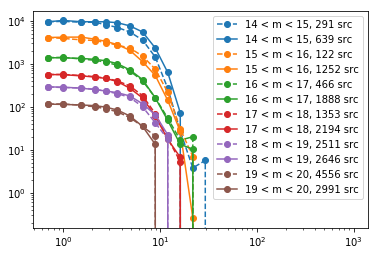

In [155]:
Nstack = stackdat_dict['Nmax']
m_min_arr = stackdat_dict['m_min_arr']
m_max_arr = stackdat_dict['m_max_arr']

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    stackdat = stackdat_dict['profPSF0'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF0'][im]['Nsrc']
    plt.loglog(stackdat['rbins'], stackdat['prof'],'o--',c='C'+str(im),label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))
    norm = stackdat['prof'][0]
    stackdat = stackdat_dict['profPSF5'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF5'][im]['Nsrc']
    norm = norm / stackdat['prof'][0]
    plt.loglog(stackdat['rbins'], stackdat['prof']*norm,'o-',c='C'+str(im),
               label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))

plt.legend()

(0.5, 10)

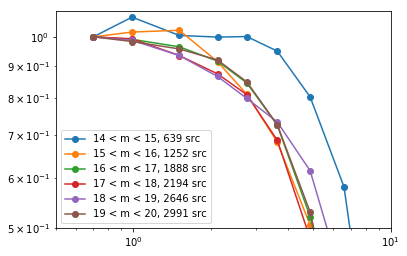

In [160]:
Nstack = stackdat_dict['Nmax']
m_min_arr = stackdat_dict['m_min_arr']
m_max_arr = stackdat_dict['m_max_arr']

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    stackdat = stackdat_dict['profPSF0'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF0'][im]['Nsrc']
#     plt.loglog(stackdat['rbins'], stackdat['prof']/stackdat['prof'][0],'o--',c='C'+str(im),label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))
    norm = stackdat['prof'][0]
    stackdat = stackdat_dict['profPSF5'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF5'][im]['Nsrc']
    norm = norm / stackdat['prof'][0]
    plt.loglog(stackdat['rbins'], stackdat['prof']/stackdat['prof'][0],'o-',c='C'+str(im),
               label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))

plt.legend()
plt.ylim([0.5,1.1])
plt.xlim([0.5,10])

# GAIA

In [228]:
# # processing GAIA data
# from utils import *
# for ifield in [4,5,6,7,8]:
#     catdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/gaiacats/'
#     catcoorddir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/catcoord/'

#     df = pd.read_csv(catdir + fieldnamedict[ifield] + '.csv')
#     df = catalog_add_xy_from_radec(fieldnamedict[ifield], df)
#     df = df[['ra','dec','x1', 'y1', 'x2', 'y2','parallax','phot_g_mean_mag']].copy()
#     fname = catcoorddir + 'GAIA/' + fieldnamedict[ifield] + '.csv'
#     df.to_csv(fname, index=False)

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [2]:
from psfstack import *

inst = 1
ifield = 6
m_min = 9
m_max = 10
psfdata_out = stack_psf(inst, data_maps[inst].stackmapdat,m_min=m_min, m_max=m_max,
 ifield_arr=[ifield], Nsub_single=True, savedata=False, save_stackmap=False, catname='GAIA')

Stack 2MASS stars for PSF ...
get data & mask in elat10
get data & mask in elat30
get data & mask in BootesB
get data & mask in BootesA
get data & mask in SWIRE
stack BootesB
stack PSF BootesB 0/9


/Users/ytcheng/ciber/python_ciber/stack_modelfit/psfstack.py:134: RuntimeWarning: invalid value encountered in greater
  (parallax==parallax) & (parallax > 1/5e3))[0]


stack PSF BootesB 1/9
stack PSF BootesB 2/9
stack PSF BootesB 3/9
stack PSF BootesB 4/9
stack PSF BootesB 5/9
stack PSF BootesB 6/9
stack PSF BootesB 7/9
stack PSF BootesB 8/9


<ErrorbarContainer object of 3 artists>

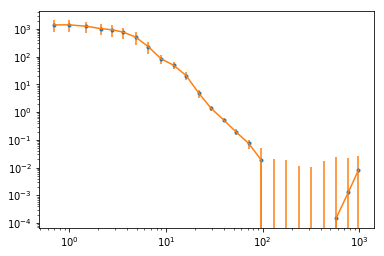

In [8]:
plt.loglog(psfdata_out[6]['rbins'],psfdata_out[6]['prof'],'.')
plt.errorbar(psfdata_out[6]['rbins'],psfdata_out[6]['prof'], psfdata_out[6]['prof_err'])

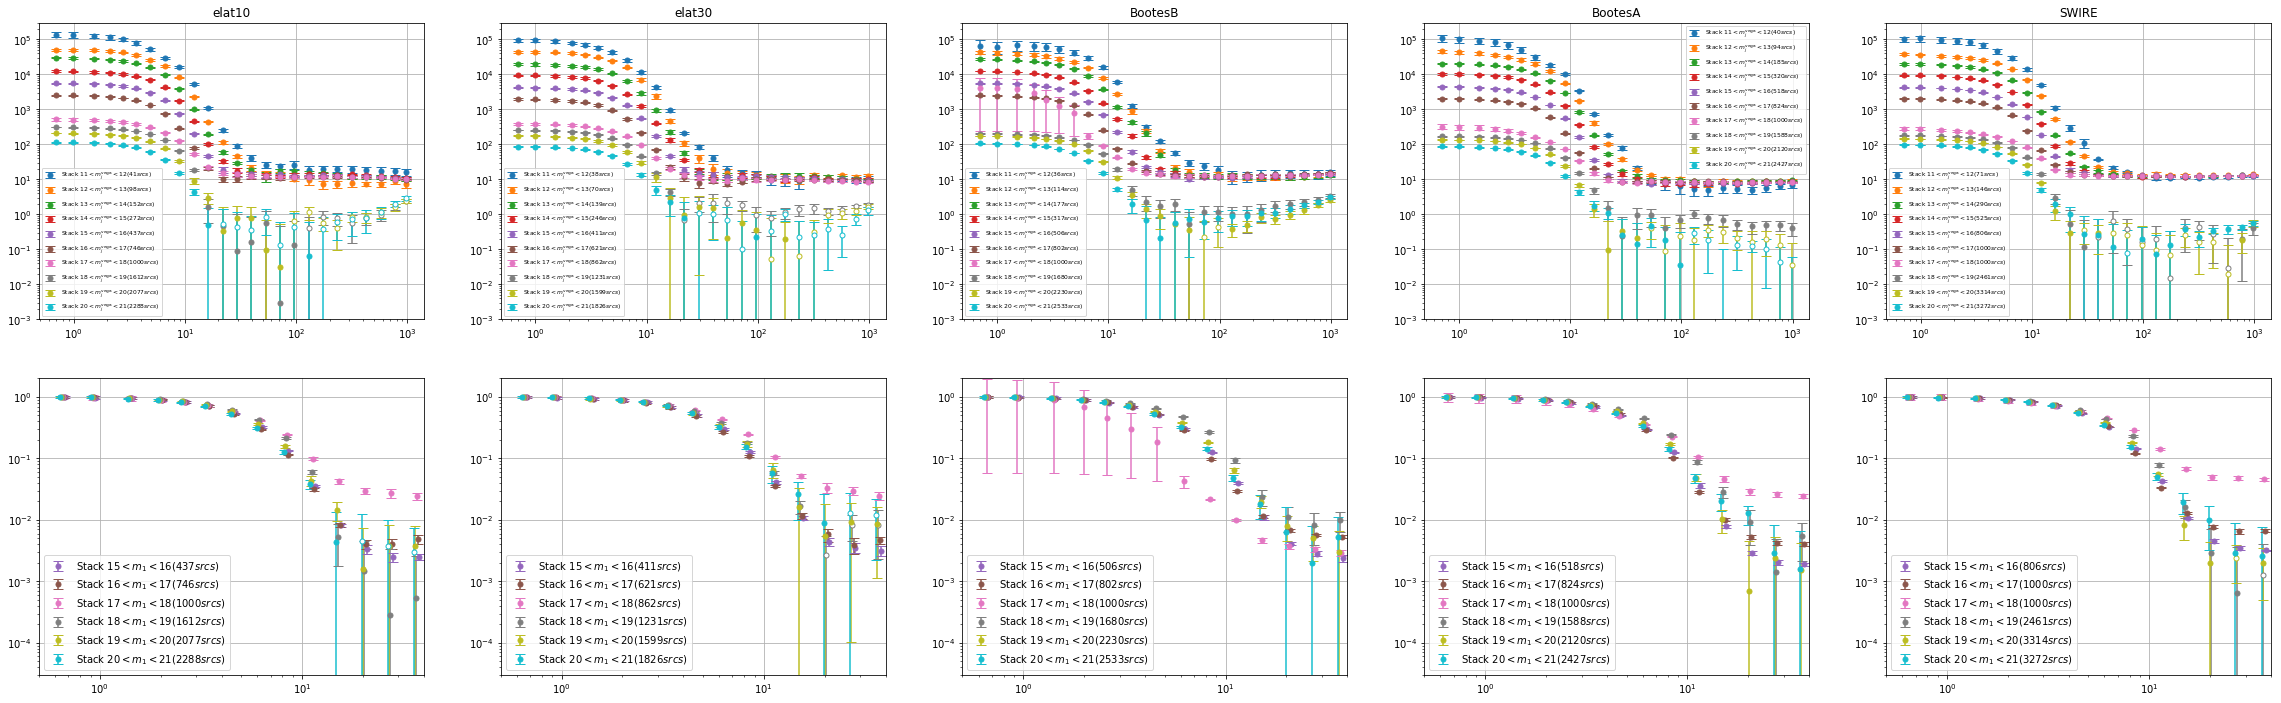

In [18]:
from psfsynth import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

psfmodel ={}
inst = 1
profc = np.zeros(25)
fig, ax = plt.subplots(2, 5, figsize = (40,12))
for i, ifield in enumerate([4,5,6,7,8]):
    for im,(m_min, m_max) in enumerate(zip(np.arange(11,21), np.arange(12,22))):
        fname = mypaths['alldat'] + 'TM'+ str(inst) +\
         '/psfdata_synth_gaia_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
        with open(fname, "rb") as f:
            profdat = pickle.load(f)
        plot_err_log(profdat['rbins'], 
                     profdat['profcb'],
                     profdat['profcb_err'], plot_xerr=False,
                     ax=ax[0][i], color='C'+str(im),
                     label=r'Stack $%d < m_j^{\rm vega} <%d (%d srcs)$'%(m_min, m_max, profdat['Nsrc']))
        if m_min > 14:
            plot_err_log(profdat['rbins']*(1-im*0.01), 
                         profdat['profcb']/profdat['profcb'][0],
                         profdat['profcb_err']/profdat['profcb'][0],
                         ax=ax[1][i], color='C'+str(im), plot_xerr=False,
                         label=r'Stack $%d < m_1 <%d (%d srcs)$'%(m_min, m_max,profdat['Nsrc']))

        
    ax[0][i].set_title(fieldnamedict[ifield])
    ax[0][i].legend(fontsize=6)
    ax[0][i].set_ylim([1e-3,3e5])
    ax[1][i].legend()
    ax[0][i].grid()
    ax[1][i].grid()
    ax[1][i].set_ylim([3e-5,2])
    ax[1][i].set_xlim([5e-1,40])
#     plt.savefig('/Users/ytcheng/Desktop/star_stack.png', dpi = 100, bbox_inches='tight')

In [2]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [ ]:
run_psf_synth_mag_all_gaia(1,6, [20],[21])
run_psf_synth_mag_all_gaia(1,7, [20],[21])
run_psf_synth_mag_all_gaia(1,8, [20],[21])

In [17]:
# from psfsynth import *

stack_gaia(1,4, data_maps=data_maps, m_min=16, m_max=17,
    filt_order=3)

{'CBmax': array([10262.29173532, 10262.29173532, 10262.29173532, 10262.29173532,
        9234.82008622,  6796.20551626,  5651.30770534,  3340.72588675,
        1650.25653932,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf]), 'rbinedges': array([7.00000000e-01, 9.42509833e-01, 1.26903541e+00, 1.70868336e+00,
       2.30064409e+00, 3.09768526e+00, 4.17085545e+00, 5.61581753e+00,
       7.56137606e+00, 1.01809590e+01, 1.37080771e+01, 1.84571392e+01,
       2.48514788e+01, 3.34610902e+01, 4.50534379e+01, 6.06618689e+01,
       8.16777256e+01, 1.09974371e+02, 1.48074180e+02, 1.99373386e+02,
       2.68444824e+02, 3.61445552e+02, 4.86665696e+02, 6.55267434e+02,
       8.82279999e+02, 1.21181697e+03]), 'rbins': array([7.00000000e-01, 9.89949494e-01, 1.51016506e

KeyboardInterrupt: 

In [15]:
def stack_gaia(inst, ifield, data_maps=None, m_min=12, m_max=14, Nsub=10,
    filt_order=3, Nsub_single=False, save_stackmap=False, savedata=True):

    if data_maps is None:
        data_maps = {1: image_reduction(1), 2: image_reduction(2)}
        
    cbmap, mask_inst= \
    load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                       (inst,ifield,'mask_inst')])
    
    # get data & mask
    catdir = mypaths['GAIAcatdat']
    df = pd.read_csv(catdir + fieldnamedict[ifield] + '.csv')
    xs = df['y'+str(inst)].values
    ys = df['x'+str(inst)].values
    ms = df['phot_g_mean_mag'].values
    sp = np.where((ms < 17) & (xs>-20) & (xs<1044) & (ys>-20) & (ys<1044))[0]
    xs, ys, ms = xs[sp], ys[sp], ms[sp]
    rs = -6.25 * ms + 110
    
    strmask = np.ones([1024,1024])
    strnum = np.zeros([1024,1024])
    for i,(x,y,r) in enumerate(zip(xs, ys, rs)):
        radmap = make_radius_map(strmask, x, y)
        strmask[radmap < r/7.] = 0
        strnum[radmap < r/7.] += 1

    Q1 = np.percentile(cbmap[(mask_inst*strmask==1)], 25)
    Q3 = np.percentile(cbmap[(mask_inst*strmask==1)], 75)
    clipmin = Q1 - 3 * (Q3 - Q1)
    clipmax = Q3 + 3 * (Q3 - Q1)
    mask_inst[(cbmap > clipmax) & (mask_inst*strmask==1)] = 0
    mask_inst[(cbmap < clipmin) & (mask_inst*strmask==1)] = 0
    
    # get cliplim
    df = df[df['parallax']==df['parallax']]
    xs = df['y'+str(inst)].values
    ys = df['x'+str(inst)].values
    ms = df['phot_g_mean_mag'].values
    parallax = df['parallax'].values
    sp = np.where((ms>m_min) & (ms<m_max) &\
     (xs>-0.5) & (xs<1023.5) & (ys>-0.5) & (ys<1023.5) &\
      (parallax > 1/5e3))[0]
    xs, ys, ms = xs[sp], ys[sp], ms[sp]
    rs = -6.25 * ms + 110
    
    nbins = 25
    dx = 1200
    profile = radial_prof(np.ones([2*dx+1,2*dx+1]), dx, dx)
    rbinedges, rbins = profile['rbinedges'], profile['rbins'] # subpix units
    cliplim = {'rbins': rbins*0.7, 'rbinedges': rbinedges*0.7,
              'CBmax': np.full((nbins), np.inf),
              'CBmin': np.full((nbins), -np.inf),
              }
    if m_max <= 17:
        if len(ms)>1000:
            sp = np.arange(len(ms))
            np.random.shuffle(sp)
            sp = sp[:1000]
        else:
            sp = np.arange(len(ms))
        x_arr, y_arr, m_arr, r_arr = xs[sp], ys[sp], ms[sp], rs[sp]


        cbdata = {}
        for i in range(len(rbins)):
            cbdata[i] = np.array([])

        for isrc in range(len(x_arr)):
            radmap = make_radius_map(cbmap, x_arr[isrc], y_arr[isrc]) # large pix units

            sp1 = np.where((radmap < r_arr[isrc]/7) & (strnum==1) & (mask_inst==1))
            if len(sp1[0])==0:
                continue
            # unmasked radii and their CBmap values
            ri = radmap[sp1]*10 # sub pix units
            cbi = cbmap[sp1]

            for ibin in range(len(rbins)):
                spi = np.where((ri>rbinedges[ibin]) & (ri<rbinedges[ibin+1]))[0]
                if len(spi)==0:
                    continue
                cbdata[ibin] = np.append(cbdata[ibin], cbi[spi])


        d = np.concatenate((cbdata[0],cbdata[1],cbdata[2],cbdata[3]))
        Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
        IQR = Q3 - Q1
        cliplim['CBmin'][:4], cliplim['CBmax'][:4]= Q1-3*IQR, Q3+3*IQR
    
        for ibin in np.arange(4,nbins,1):
            d = cbdata[ibin]
            if len(d)==0:
                continue
            Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
            IQR = Q3 - Q1
            cliplim['CBmin'][ibin], cliplim['CBmax'][ibin]= Q1-3*IQR, Q3+3*IQR
    
    print(cliplim)
    # stack
    stack_class = stacking_mock(inst)
    psfdata = {}

    prof_arr = []
    profhit_arr = []
    profsub_arr = []
    profsubhit_arr = []
    mapstack, maskstack = 0., 0.

    if len(xs) < Nsub:
        Nsub_single = True

    if Nsub_single:
        Nsub = len(xs)

    for isub in range(Nsub):
        print('stack PSF %s %d/%d'%(fieldnamedict[ifield],isub,Nsub))
        stack_class.xls = xs[isub::Nsub]
        stack_class.yls = ys[isub::Nsub]
        stack_class.ms = ms[isub::Nsub]
        stack_class.rs = rs[isub::Nsub]

        stackdat, stacki, maskstacki, mapstacki \
        = stack_class.run_stacking(cbmap, mask_inst*strmask, strnum, 
                                   mask_inst=mask_inst,return_all=True,
                                    update_mask=False, verbose=True)
        mapstack += mapstacki
        maskstack += maskstacki

        prof_arr.append(stackdat['prof'])
        profhit_arr.append(stackdat['profhit'])
        profsub_arr.append(stackdat['profsub'])
        profsubhit_arr.append(stackdat['profhitsub'])

    stack = np.zeros_like(mapstack)
    sp = np.where(maskstack!=0)
    stack[sp] = mapstack[sp] / maskstack[sp]
    stack[maskstack==0] = 0

    prof_arr = np.array(prof_arr)
    profhit_arr = np.array(profhit_arr)
    profsub_arr = np.array(profsub_arr)
    profsubhit_arr = np.array(profsubhit_arr)

    prof = (np.sum(prof_arr * profhit_arr, axis=0) / np.sum(profhit_arr, axis=0))
    profsub = (np.sum(profsub_arr * profsubhit_arr, axis=0) / np.sum(profsubhit_arr, axis=0))  

    profjack_arr = np.zeros_like(prof_arr)
    profsubjack_arr = np.zeros_like(profsub_arr)

    for isub in range(Nsub):
        proftot = np.sum(prof_arr * profhit_arr, axis=0)
        profi = prof_arr[isub] * profhit_arr[isub]
        hittot = np.sum(profhit_arr, axis=0)
        hiti = profhit_arr[isub]
        profjack_arr[isub] = (proftot - profi) / (hittot - hiti)

        proftot = np.sum(profsub_arr * profsubhit_arr, axis=0)
        profi = profsub_arr[isub] * profsubhit_arr[isub]
        hittot = np.sum(profsubhit_arr, axis=0)
        hiti = profsubhit_arr[isub]    
        profsubjack_arr[isub] = (proftot - profi) / (hittot - hiti)

    cov = np.zeros([len(prof),len(prof)])
    for i in range(len(prof)):
        for j in range(len(prof)):
            cov[i,j] = np.mean(profjack_arr[:,i]*profjack_arr[:,j]) \
            - np.mean(profjack_arr[:,i])*np.mean(profjack_arr[:,j])
    cov *= (Nsub-1)

    covsub = np.zeros([len(profsub),len(profsub)])
    for i in range(len(profsub)):
        for j in range(len(profsub)):
            covsub[i,j] = np.mean(profsubjack_arr[:,i]*profsubjack_arr[:,j]) \
            - np.mean(profsubjack_arr[:,i])*np.mean(profsubjack_arr[:,j])
    covsub *= (Nsub-1)

    profdat = {}
    profdat['Nsrc'] = len(xs)
    profdat['m_min'] = m_min
    profdat['m_max'] = m_max
    profdat['rbins'] = stackdat['rbins'].copy()
    profdat['rbinedges'] = stackdat['rbinedges'].copy()
    profdat['rsubbins'] = stackdat['rsubbins'].copy()
    profdat['rsubbinedges'] = stackdat['rsubbinedges'].copy()
    profdat['profcb'] = prof
    profdat['profcbsub'] = profsub
    profdat['profhit'] = np.sum(profhit_arr,axis=0)
    profdat['profcb_err'] = np.sqrt(np.diag(cov))
    profdat['profcbsub_err'] = np.sqrt(np.diag(covsub))
    profdat['cov'] = cov
    profdat['covsub'] = covsub
    if save_stackmap:
        profdat['stackmap'] = stack

    if savedata:
        fname = mypaths['alldat'] + 'TM'+ str(inst) +\
         '/psfdata_synth_gaia_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
        with open(fname, "wb") as f:
            pickle.dump(profdat, f)

    return profdat

